In [65]:
import numpy as np  # This helps us work with arrays (lists of numbers).
from sklearn.linear_model import OrthogonalMatchingPursuit  # This helps us find sparse representations.
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  # For plotting graphs.

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

measurement = np.load('../dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs']

# Define channels
legit_channel = 3  # Channel 3 is legitimate
illegit_channel = 6  # Channel 6 is illegitimate

# Extract data for legitimate and illegitimate channels
alice_CIRs = data_cir[:, legit_channel, :, :]  # Shape: (9797, 251, 2)
eve_CIRs = data_cir[:, illegit_channel, :, :]  # Shape: (9797, 251, 2)

print(alice_CIRs.shape)
print(eve_CIRs.shape)

alice_atoms = alice_CIRs.reshape(9797, -1)  # '-1' means we flatten the last two dimensions.
eve_atoms = eve_CIRs.reshape(9797, -1)  # Do the same for Eve.

dictionary = np.vstack((alice_atoms, eve_atoms))  # 'vstack' stacks them vertically.
dictionary = dictionary.T  # This flips the array so rows become columns.

test_signal = alice_atoms[5000].reshape(-1)  # Flatten the first sample from Alice.

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=2, tol=1e-3)  # Increase n_nonzero_coefs and tolerance
omp.fit(dictionary, test_signal)

coefficients = omp.coef_



# Start with an empty list to store residuals.
residuals = []
coef_class = np.zeros_like(coefficients)

# We have two classes: Alice (0) and Eve (1).
for i in range(2):
    # Create an array of zeros like the coefficients.
    coef_class = np.zeros_like(coefficients)
    if i == 0:
        # For Alice, keep her coefficients (first 5), set Eve's to zero.
        coef_class[:9797] = coefficients[:9797]
    else:
        # For Eve, keep her coefficients (last 9797), set Alice's to zero.
        coef_class[9797:] = coefficients[9797:]
    # Reconstruct the signal using only the coefficients from one class.
    reconstructed_signal = dictionary @ coef_class
    # Calculate the residual (difference between test signal and reconstructed signal).
    residual = np.linalg.norm(test_signal - reconstructed_signal)
    # Add the residual to the list.
    residuals.append(residual)

print(residuals)


# Find which class has the smallest residual.
predicted_class = np.argmin(residuals)

# Now, we print out which class the test signal belongs to.
if predicted_class == 0:
    print("The test signal is classified as Alice.")
else:
    print("The test signal is classified as Eve.")


(9797, 251, 2)
(9797, 251, 2)
[6.9176090817643695e-12, 44701.23547509621]
The test signal is classified as Alice.


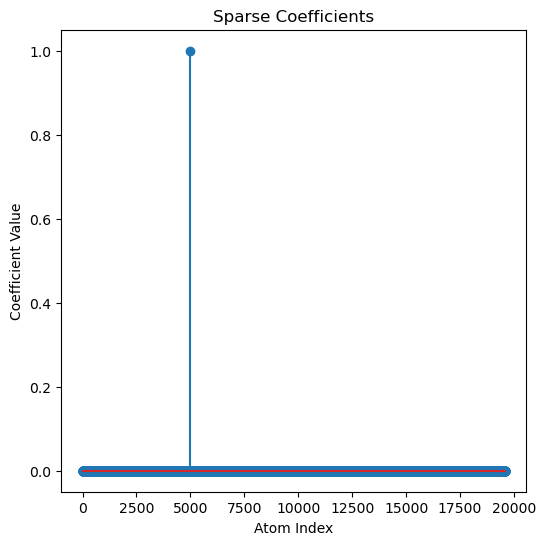

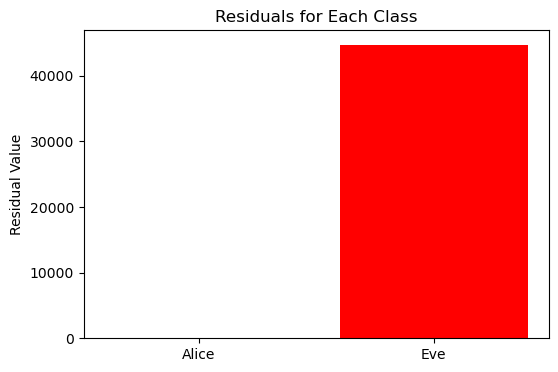

In [66]:
# Now, let's plot the coefficients and residuals.

# 1. Plotting the Sparse Coefficients.
plt.figure(figsize=(6, 6))  # Create a new figure with a specified size.
plt.stem(coefficients)  # Plot the coefficients as stems (lines with dots).
plt.title('Sparse Coefficients')  # Title of the plot.
plt.xlabel('Atom Index')  # Label for the x-axis.
plt.ylabel('Coefficient Value')  # Label for the y-axis.
plt.show()  # Display the plot.

# 2. Plotting the Residuals.
classes = ['Alice', 'Eve']  # Names of the classes.
plt.figure(figsize=(6, 4))  # Create a new figure.
plt.bar(classes, residuals, color=['blue', 'red'])  # Create a bar chart.
plt.title('Residuals for Each Class')  # Title of the plot.
plt.ylabel('Residual Value')  # Label for the y-axis.
plt.show()  # Display the plot.